# Лабораторная 3

## Многослойный перцептрон (MLP) для нелинейных данных


### Блок 1. Импорты


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Блок 2.


In [18]:
class MLP:
    """Многослойный перцептрон на чистом NumPy"""
    
    def __init__(self, input_size=2, hidden_size=4, output_size=1):
        """
        Инициализация MLP
        
        Архитектура:
        Вход (input_size) → Скрытый слой (hidden_size, ReLU) → Выход (output_size, Sigmoid)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Инициализация весов методом Xavier/Glorot
        # W1: веса между входом и скрытым слоем
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        # W2: веса между скрытым и выходным слоем
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        print(f"Создан MLP: {input_size} → {hidden_size} → {output_size}")
        print(f"Параметры: W1: {self.W1.shape}, b1: {self.b1.shape}")
        print(f"          W2: {self.W2.shape}, b2: {self.b2.shape}")
    
    def relu(self, x):
        """Функция активации ReLU"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Производная ReLU"""
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        """Функция активации Sigmoid"""
        # Защита от переполнения
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Производная Sigmoid: σ'(x) = σ(x) * (1 - σ(x))"""
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X):
        """Прямой проход"""
        # Скрытый слой
        self.z1 = np.dot(X, self.W1) + self.b1  # Взвешенная сумма
        self.a1 = self.relu(self.z1)            # Активация ReLU
        
        # Выходной слой
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Взвешенная сумма
        self.a2 = self.sigmoid(self.z2)               # Активация Sigmoid
        
        return self.a2
    
    def backward(self, X, y, output, learning_rate=0.01):
        """Обратное распространение ошибки"""
        m = X.shape[0]  # Количество примеров
        
        # Градиенты выходного слоя
        dz2 = output - y  # Ошибка
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Градиенты скрытого слоя
        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Обновление весов
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def predict(self, X, threshold=0.5):
        """Предсказание"""
        output = self.forward(X)
        return (output >= threshold).astype(int)
    
    def compute_loss(self, y_true, y_pred_proba):
        """Вычисление бинарной кросс-энтропии"""
        # Защита от log(0)
        y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
        loss = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
        return loss

# Тестируем создание MLP
mlp = MLP(input_size=2, hidden_size=4, output_size=1)

Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)


### Блок 3.


In [19]:
def generate_data(data_type='moons', n_samples=1000, noise=0.2):
    """Генерация нелинейно разделимых данных"""
    
    if data_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
        title = "Две пересекающиеся луны"
    
    elif data_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=42)
        title = "Два концентрических круга"
    
    elif data_type == 'xor':
        # Четкие 4 кластера XOR + малый шум
        centers = np.array([[0,0], [0,1], [1,0], [1,1]])
        labels = np.array([0, 1, 1, 0])
        X = np.repeat(centers, 250, axis=0)  # 250 точек на кластер
        X = X.astype(float) + np.random.normal(0, 0.05, X.shape)  # Малый шум 0.05
        y = np.repeat(labels, 250)
        title = "Задача XOR (4 четких кластера)"
    
    else:
        # Простые линейно разделимые данные для сравнения
        X, y = make_classification(
            n_samples=n_samples, n_features=2, n_informative=2,
            n_redundant=0, n_clusters_per_class=1,
            random_state=42
        )
        title = "Линейно разделимые данные"
    
    return X, y, title

# Создаем разные наборы данных
data_types = ['moons', 'circles', 'xor', 'linear']
datasets = {}

for data_type in data_types:
    X, y, title = generate_data(data_type, n_samples=1000)
    datasets[data_type] = {'X': X, 'y': y, 'title': title}
    
print("Данные сгенерированы!")
print(f"Доступные наборы: {list(datasets.keys())}")

Данные сгенерированы!
Доступные наборы: ['moons', 'circles', 'xor', 'linear']


### Блок 4.


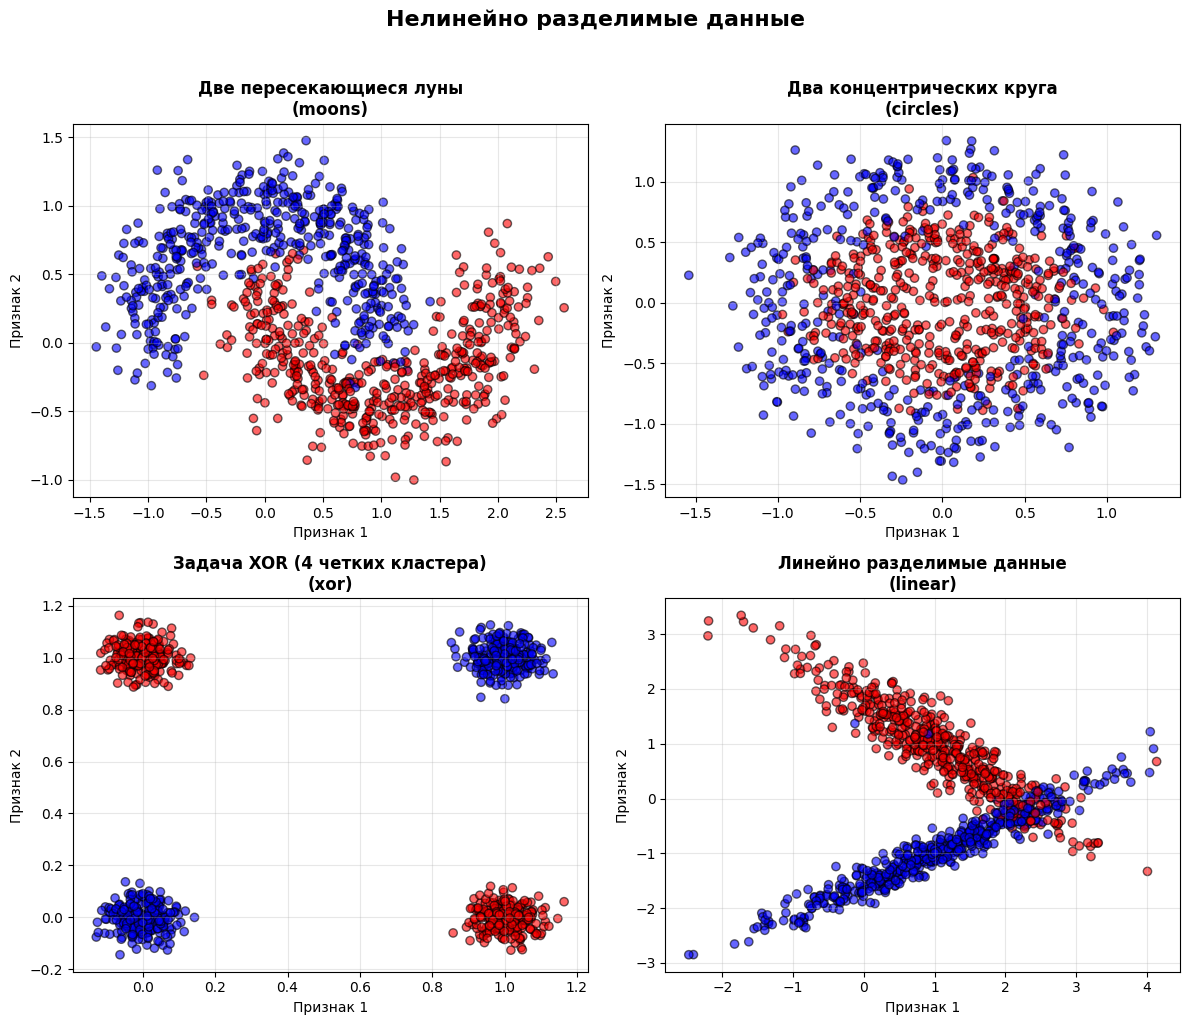

In [20]:
def plot_datasets(datasets):
    """Визуализация всех наборов данных"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, (data_type, data) in enumerate(datasets.items()):
        ax = axes[idx]
        X, y = data['X'], data['y']
        
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6, edgecolors='k')
        ax.set_title(f"{data['title']}\n({data_type})", fontsize=12, fontweight='bold')
        ax.set_xlabel('Признак 1')
        ax.set_ylabel('Признак 2')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Нелинейно разделимые данные', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_datasets(datasets)

### Блок 5.


In [21]:
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01, verbose=True):
    """Обучение MLP"""
    
    # Преобразуем y в нужную форму (n_samples, 1)
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    
    # Для отслеживания прогресса
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print(f"Начало обучения на {epochs} эпох...")
    print(f"Размер обучающей выборки: {X_train.shape[0]}")
    print(f"Размер валидационной выборки: {X_val.shape[0]}")
    
    for epoch in range(epochs):
        # Прямой проход на обучающих данных
        train_output = model.forward(X_train)
        train_loss = model.compute_loss(y_train, train_output)
        train_losses.append(train_loss)
        
        # Обратное распространение
        model.backward(X_train, y_train, train_output, learning_rate)
        
        # Предсказания и точность на обучающих данных
        train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_accuracies.append(train_acc)
        
        # Валидация
        val_output = model.forward(X_val)
        val_loss = model.compute_loss(y_val, val_output)
        val_losses.append(val_loss)
        
        val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        val_accuracies.append(val_acc)
        
        # Вывод прогресса
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Эпоха {epoch+1:4d}/{epochs} | "
                  f"Потеря: train={train_loss:.4f}, val={val_loss:.4f} | "
                  f"Точность: train={train_acc:.2%}, val={val_acc:.2%}")
    
    print("Обучение завершено!")
    
    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'final_train_acc': train_acc,
        'final_val_acc': val_acc
    }
    
    return results

### Блок 6.


In [22]:
def prepare_and_train(data_type='moons', hidden_size=4, epochs=1000, lr=0.01):
    """Подготовка данных и обучение модели"""
    
    print(f"\n{'='*60}")
    print(f"ЭКСПЕРИМЕНТ С ДАННЫМИ: {data_type.upper()}")
    print(f"{'='*60}")
    
    # Берем данные
    X, y = datasets[data_type]['X'], datasets[data_type]['y']
    
    if data_type == 'xor':
        lr = 0.3  # Быстро для XOR
    elif data_type == 'circles':
        lr = 0.05  # Средне для circles
    else:
        lr = 0.01  # Стандарт для moons/linear
    
    # Нормализация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Разделение на train/validation/test (70/15/15)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y  # 80/20!
    )
    X_val, y_val = X_test, y_test.copy()
    
    print(f"\nРазделение данных (80/20):")
    print(f"  Обучающая: {X_train.shape[0]} примеров (80%)")
    print(f"  Тестовая/валидационная: {X_test.shape[0]} примеров (20%)")
    
    # Создаем и обучаем модель
    model = MLP(input_size=2, hidden_size=hidden_size, output_size=1)
    results = train_mlp(
        model, X_train, y_train, X_val, y_val,
        epochs=epochs, learning_rate=lr, verbose=True
    )
    
    # Оценка на тестовых данных
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"\nТочность на тестовых данных: {test_acc:.2%}")
    
    return model, results, X_train, y_train, X_val, y_val, X_test, y_test, scaler

# Запускаем обучение на moons
model_moons, results_moons, X_train_m, y_train_m, X_val_m, y_val_m, X_test_m, y_test_m, scaler_m = prepare_and_train(
    data_type='moons', hidden_size=4, epochs=1000, lr=0.01
)


ЭКСПЕРИМЕНТ С ДАННЫМИ: MOONS

Разделение данных (80/20):
  Обучающая: 800 примеров (80%)
  Тестовая/валидационная: 200 примеров (20%)
Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)
Начало обучения на 1000 эпох...
Размер обучающей выборки: 800
Размер валидационной выборки: 200
Эпоха  100/1000 | Потеря: train=0.6301, val=0.6155 | Точность: train=52.00%, val=51.50%
Эпоха  200/1000 | Потеря: train=0.5364, val=0.5128 | Точность: train=85.50%, val=93.00%
Эпоха  300/1000 | Потеря: train=0.4735, val=0.4418 | Точность: train=85.88%, val=93.50%
Эпоха  400/1000 | Потеря: train=0.4273, val=0.3885 | Точность: train=86.12%, val=93.00%
Эпоха  500/1000 | Потеря: train=0.3935, val=0.3480 | Точность: train=86.25%, val=92.50%
Эпоха  600/1000 | Потеря: train=0.3692, val=0.3178 | Точность: train=86.00%, val=92.00%
Эпоха  700/1000 | Потеря: train=0.3524, val=0.2957 | Точность: train=86.00%, val=92.00%
Эпоха  800/1000 | Потеря: train=0.3408, val=0.2795 | Точность: t

### Блок 7.


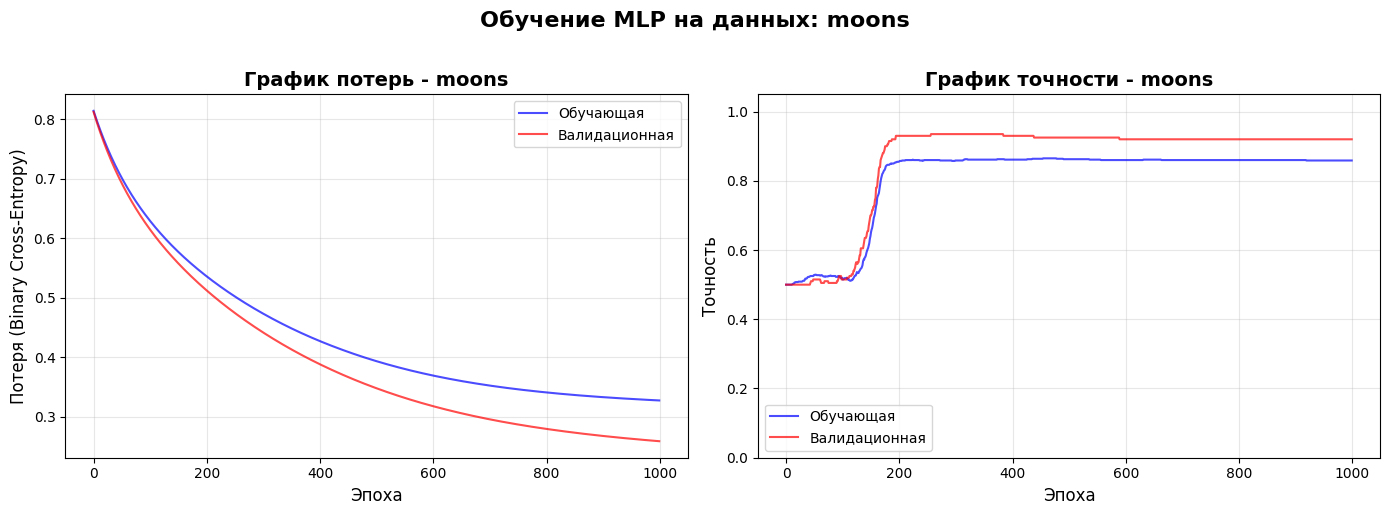


Финальные метрики для moons:
  Обучающая точность: 85.88%
  Валидационная точность: 92.00%


In [23]:
def plot_training_results(results, data_type):
    """Визуализация результатов обучения"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # График потерь
    axes[0].plot(results['train_losses'], 'b-', label='Обучающая', alpha=0.7)
    axes[0].plot(results['val_losses'], 'r-', label='Валидационная', alpha=0.7)
    axes[0].set_xlabel('Эпоха', fontsize=12)
    axes[0].set_ylabel('Потеря (Binary Cross-Entropy)', fontsize=12)
    axes[0].set_title(f'График потерь - {data_type}', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График точности
    axes[1].plot(results['train_accuracies'], 'b-', label='Обучающая', alpha=0.7)
    axes[1].plot(results['val_accuracies'], 'r-', label='Валидационная', alpha=0.7)
    axes[1].set_xlabel('Эпоха', fontsize=12)
    axes[1].set_ylabel('Точность', fontsize=12)
    axes[1].set_title(f'График точности - {data_type}', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1.05)
    
    plt.suptitle(f'Обучение MLP на данных: {data_type}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nФинальные метрики для {data_type}:")
    print(f"  Обучающая точность: {results['final_train_acc']:.2%}")
    print(f"  Валидационная точность: {results['final_val_acc']:.2%}")

plot_training_results(results_moons, 'moons')

### Блок 8.


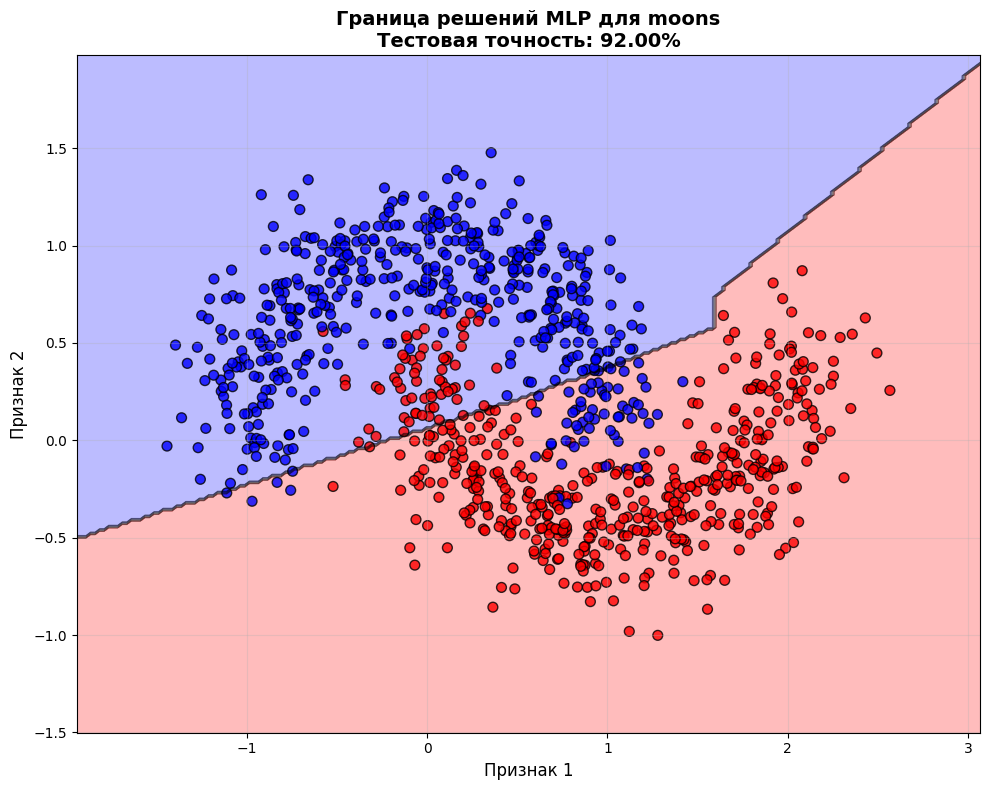

In [24]:
def plot_decision_boundary(model, X, y, scaler, title="Граница решений MLP"):
    """Визуализация границы решений"""
    
    # Создаем сетку
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Предсказания для сетки
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    Z = model.predict(grid_points_scaled)
    Z = Z.reshape(xx.shape)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    
    # Фон с границами
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)
    
    # Обучающие точки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', 
                edgecolors='k', s=50, alpha=0.8)
    
    plt.xlabel('Признак 1', fontsize=12)
    plt.ylabel('Признак 2', fontsize=12)
    plt.title(f'{title}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Визуализируем для moons
X_moons = datasets['moons']['X']
y_moons = datasets['moons']['y']
plot_decision_boundary(model_moons, X_moons, y_moons, scaler_m, 
                       title=f"Граница решений MLP для moons\nТестовая точность: {accuracy_score(y_test_m, model_moons.predict(X_test_m)):.2%}")

### Блок 9.



РЕШЕНИЕ ЗАДАЧИ XOR МНОГОСЛОЙНЫМ ПЕРСЕПТРОНОМ

ЭКСПЕРИМЕНТ С ДАННЫМИ: XOR

Разделение данных (80/20):
  Обучающая: 800 примеров (80%)
  Тестовая/валидационная: 200 примеров (20%)
Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)
Начало обучения на 500 эпох...
Размер обучающей выборки: 800
Размер валидационной выборки: 200
Эпоха  100/500 | Потеря: train=0.3508, val=0.3881 | Точность: train=75.00%, val=72.50%
Эпоха  200/500 | Потеря: train=0.3437, val=0.3818 | Точность: train=75.38%, val=72.50%
Эпоха  300/500 | Потеря: train=0.3417, val=0.3802 | Точность: train=75.38%, val=72.50%
Эпоха  400/500 | Потеря: train=0.3408, val=0.3795 | Точность: train=75.50%, val=72.50%
Эпоха  500/500 | Потеря: train=0.3402, val=0.3791 | Точность: train=75.50%, val=72.50%
Обучение завершено!

Точность на тестовых данных: 72.50%


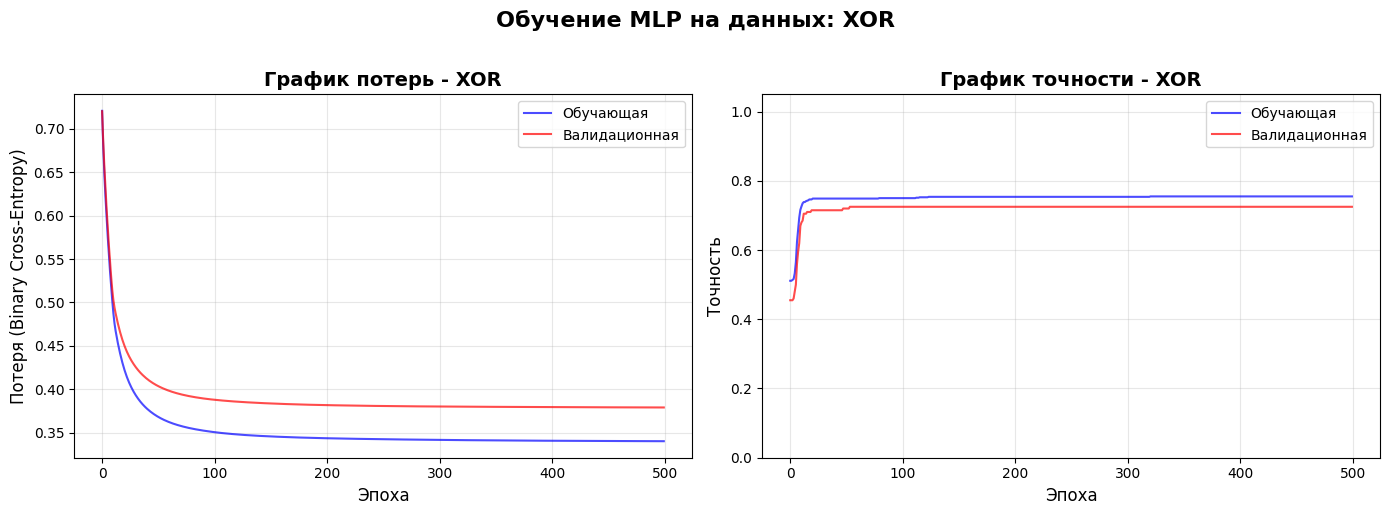


Финальные метрики для XOR:
  Обучающая точность: 75.50%
  Валидационная точность: 72.50%


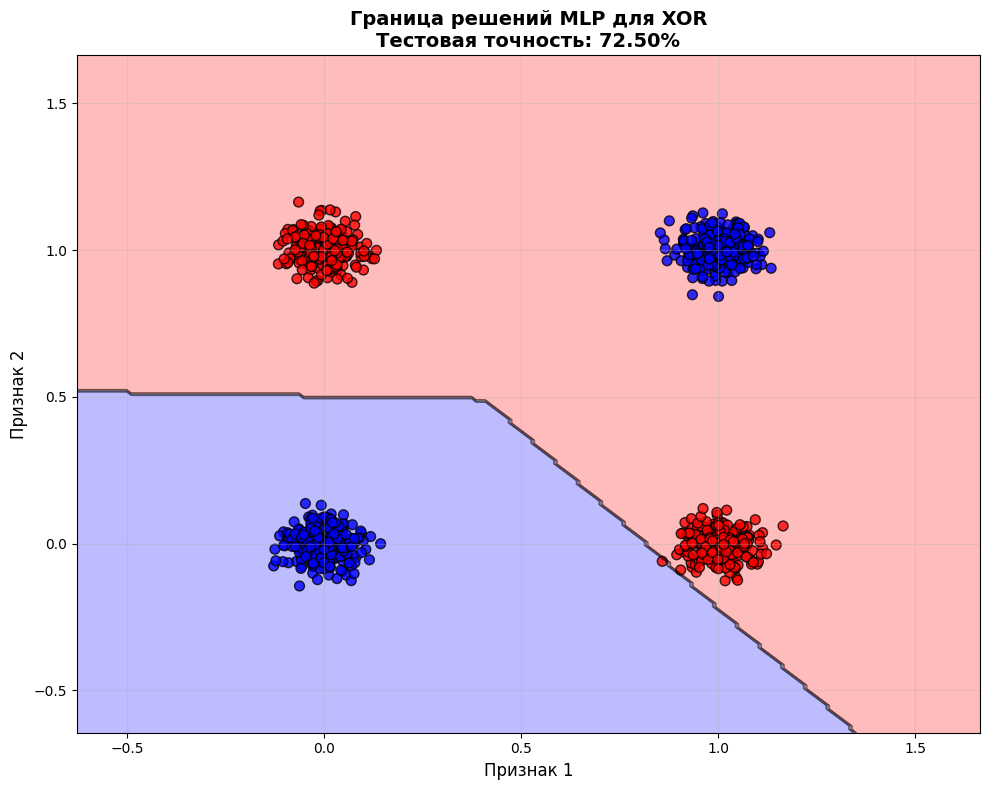

In [25]:
print("\n" + "="*60)
print("РЕШЕНИЕ ЗАДАЧИ XOR МНОГОСЛОЙНЫМ ПЕРСЕПТРОНОМ")
print("="*60)

# Обучаем на XOR
model_xor, results_xor, X_train_x, y_train_x, X_val_x, y_val_x, X_test_x, y_test_x, scaler_x = prepare_and_train(
    data_type='xor', hidden_size=4, epochs=500, lr=0.01
)

# Визуализация
plot_training_results(results_xor, 'XOR')

# Граница решений для XOR
X_xor = datasets['xor']['X']
y_xor = datasets['xor']['y']
plot_decision_boundary(model_xor, X_xor, y_xor, scaler_x,
                       title=f"Граница решений MLP для XOR\nТестовая точность: {accuracy_score(y_test_x, model_xor.predict(X_test_x)):.2%}")

### Блок 10.



Сравнение архитектур для moons:
------------------------------------------------------------
Без скрытого слоя (логистическая регрессия) Точность: 90.00%
Создан MLP: 2 → 2 → 1
Параметры: W1: (2, 2), b1: (1, 2)
          W2: (2, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
2 нейрона                                Точность: 84.67%
Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
4 нейрона                                Точность: 86.00%
Создан MLP: 2 → 8 → 1
Параметры: W1: (2, 8), b1: (1, 8)
          W2: (8, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
8 нейронов                               Точность: 88.00%
Создан MLP: 2 → 16 → 1
Параметры: W1: (2, 16), b1: (1, 16)


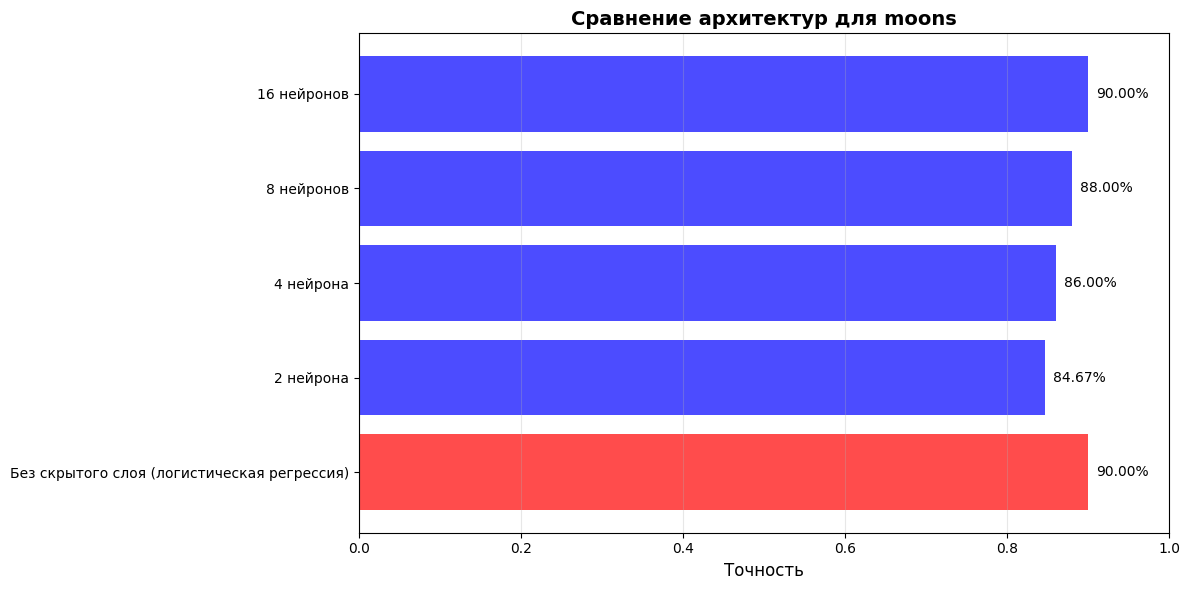


Сравнение архитектур для circles:
------------------------------------------------------------
Без скрытого слоя (логистическая регрессия) Точность: 52.00%
Создан MLP: 2 → 2 → 1
Параметры: W1: (2, 2), b1: (1, 2)
          W2: (2, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
2 нейрона                                Точность: 43.33%
Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
4 нейрона                                Точность: 62.00%
Создан MLP: 2 → 8 → 1
Параметры: W1: (2, 8), b1: (1, 8)
          W2: (8, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
8 нейронов                               Точность: 46.67%
Создан MLP: 2 → 16 → 1
Параметры: W1: (2, 16), b1: (1, 16

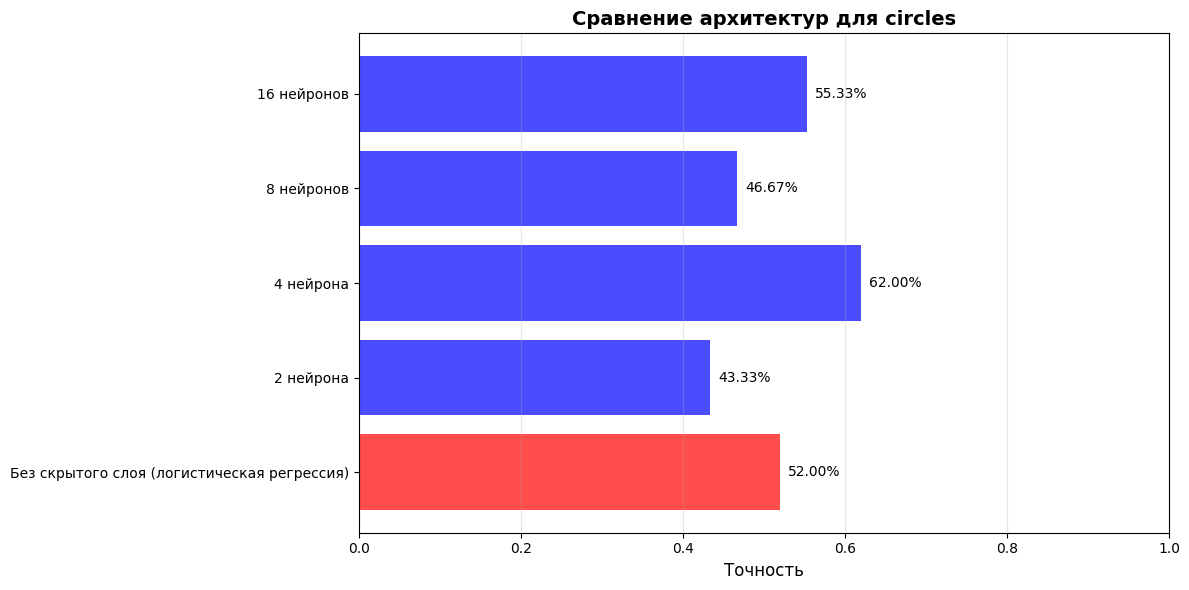


Сравнение архитектур для xor:
------------------------------------------------------------
Без скрытого слоя (логистическая регрессия) Точность: 48.67%
Создан MLP: 2 → 2 → 1
Параметры: W1: (2, 2), b1: (1, 2)
          W2: (2, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
2 нейрона                                Точность: 50.00%
Создан MLP: 2 → 4 → 1
Параметры: W1: (2, 4), b1: (1, 4)
          W2: (4, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
4 нейрона                                Точность: 93.33%
Создан MLP: 2 → 8 → 1
Параметры: W1: (2, 8), b1: (1, 8)
          W2: (8, 1), b2: (1, 1)
Начало обучения на 300 эпох...
Размер обучающей выборки: 700
Размер валидационной выборки: 150
Обучение завершено!
8 нейронов                               Точность: 100.00%
Создан MLP: 2 → 16 → 1
Параметры: W1: (2, 16), b1: (1, 16)
 

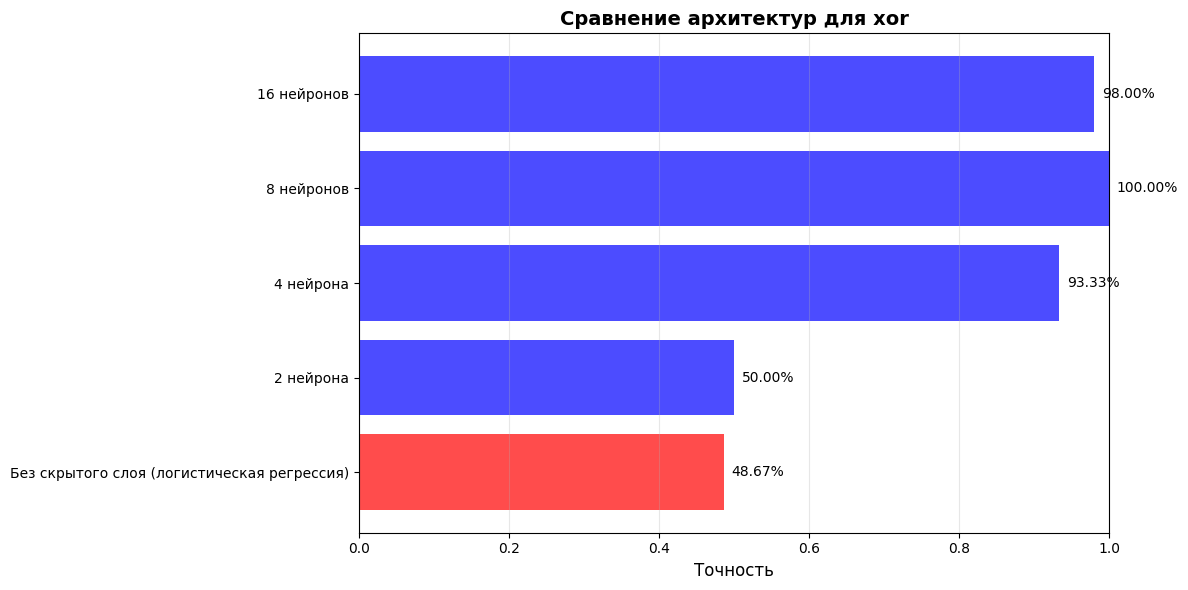

In [26]:
def compare_architectures(data_type='moons'):
    """Сравнение разных архитектур MLP"""
    
    X, y = datasets[data_type]['X'], datasets[data_type]['y']
    
    # Нормализация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Разделение
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    architectures = [
        (2, "Без скрытого слоя (логистическая регрессия)"),
        (2, "2 нейрона"),
        (4, "4 нейрона"),
        (8, "8 нейронов"),
        (16, "16 нейронов")
    ]
    
    results = {}
    
    print(f"\nСравнение архитектур для {data_type}:")
    print("-"*60)
    
    for hidden_size, desc in architectures:
        if hidden_size == 2 and desc == "Без скрытого слоя (логистическая регрессия)":
            # Логистическая регрессия
            from sklearn.linear_model import LogisticRegression
            lr = LogisticRegression(max_iter=1000)
            lr.fit(X_train, y_train)
            test_acc = lr.score(X_test, y_test)
            results[desc] = test_acc
            print(f"{desc:40} Точность: {test_acc:.2%}")
        else:
            # MLP
            model = MLP(input_size=2, hidden_size=hidden_size, output_size=1)
            
            # Быстрое обучение
            train_results = train_mlp(
                model, X_train, y_train, X_val, y_val,
                epochs=300, learning_rate=0.01, verbose=False
            )
            
            test_pred = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_pred)
            results[desc] = test_acc
            print(f"{desc:40} Точность: {test_acc:.2%}")
    
    # Визуализация сравнения
    fig, ax = plt.subplots(figsize=(12, 6))
    
    descriptions = list(results.keys())
    accuracies = list(results.values())
    
    colors = ['red' if 'Без скрытого' in desc else 'blue' for desc in descriptions]
    
    bars = ax.barh(descriptions, accuracies, color=colors, alpha=0.7)
    ax.set_xlabel('Точность', fontsize=12)
    ax.set_title(f'Сравнение архитектур для {data_type}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Добавляем значения на график
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{acc:.2%}', va='center')
    
    plt.tight_layout()
    plt.show()

# Сравниваем для разных типов данных
for data_type in ['moons', 'circles', 'xor']:
    compare_architectures(data_type)

### Блок 11.


In [27]:
def analyze_model(model, X_test, y_test, X_original, scaler):
    """Подробный анализ обученной модели"""
    
    print("\n" + "="*60)
    print("ПОДРОБНЫЙ АНАЛИЗ МОДЕЛИ")
    print("="*60)
    
    # Предсказания
    y_pred = model.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Класс 0', 'Класс 1'])
    
    print(f"\nТочность: {accuracy:.2%}")
    
    print("\nМатрица ошибок:")
    print(f"          Предсказано 0  Предсказано 1")
    print(f"Истина 0      {cm[0,0]:4d}            {cm[0,1]:4d}")
    print(f"Истина 1      {cm[1,0]:4d}            {cm[1,1]:4d}")
    
    print("\nОтчет о классификации:")
    print(report)
    
    # Анализ весов
    print("\nАнализ весов модели:")
    print(f"W1 (вход → скрытый): форма {model.W1.shape}")
    print(f"  Среднее: {np.mean(np.abs(model.W1)):.4f}")
    print(f"  Стандартное отклонение: {np.std(model.W1):.4f}")
    
    print(f"\nW2 (скрытый → выход): форма {model.W2.shape}")
    print(f"  Среднее: {np.mean(np.abs(model.W2)):.4f}")
    print(f"  Стандартное отклонение: {np.std(model.W2):.4f}")
    
    # Анализ активаций
    print("\nАнализ активаций на тестовых данных:")
    activations = model.forward(X_test)
    print(f"  Выход сигмоиды: min={activations.min():.4f}, max={activations.max():.4f}")
    print(f"  Среднее значение: {activations.mean():.4f}")
    
    # Пример работы сети
    print("\nПример работы сети на 5 тестовых примерах:")
    for i in range(min(5, len(X_test))):
        x = X_test[i:i+1]
        y_true = y_test[i]
        
        # Прямой проход с промежуточными значениями
        z1 = np.dot(x, model.W1) + model.b1
        a1 = model.relu(z1)
        z2 = np.dot(a1, model.W2) + model.b2
        a2 = model.sigmoid(z2)
        prediction = (a2 >= 0.5).astype(int)[0, 0]
        
        print(f"  Пример {i+1}: истинный класс={y_true}, предсказанный={prediction}")
        print(f"    Вход: {x[0]}")
        print(f"    Скрытый слой (после ReLU): {a1[0]}")
        print(f"    Выход сигмоиды: {a2[0, 0]:.4f}")
        print()

# Анализируем модель для moons
analyze_model(model_moons, X_test_m, y_test_m, X_moons, scaler_m)


ПОДРОБНЫЙ АНАЛИЗ МОДЕЛИ

Точность: 92.00%

Матрица ошибок:
          Предсказано 0  Предсказано 1
Истина 0        95               5
Истина 1        11              89

Отчет о классификации:
              precision    recall  f1-score   support

     Класс 0       0.90      0.95      0.92       100
     Класс 1       0.95      0.89      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200


Анализ весов модели:
W1 (вход → скрытый): форма (2, 4)
  Среднее: 0.6851
  Стандартное отклонение: 0.8433

W2 (скрытый → выход): форма (4, 1)
  Среднее: 0.6126
  Стандартное отклонение: 0.7417

Анализ активаций на тестовых данных:
  Выход сигмоиды: min=0.0461, max=0.9934
  Среднее значение: 0.5092

Пример работы сети на 5 тестовых примерах:
  Пример 1: истинный класс=1, предсказанный=0
    Вход: [-0.33434854 -0.22159652]
    Скрытый слой (после ReLU): [0.15864298 0.         